In [772]:
using Pkg
Pkg.activate("/home/users/shubhgup/Codes/Julia/TISExperiments.jl")

  Activating environment at `~/Codes/Julia/TISExperiments.jl/Project.toml`


In [773]:
ENV["PYTHON"] = "/home/groups/gracegao/conda_envs/deep_gnss/bin/python"

"/home/groups/gracegao/conda_envs/deep_gnss/bin/python"

In [774]:
using Revise

In [775]:
using POMDPs, POMDPGym, POMDPSimulators, POMDPPolicies, Distributions
using BSON
using SARSOP, Random
using POMCPOW
using BeliefUpdaters
using ParticleFilters
using FileIO
using TISExperiments
using POMDPGifs
using D3Trees
# using Interact
using TreeImportanceSampling
include("scenarioselection_mdp.jl")
include("local_pomdpgym.jl")

In [776]:
using Plots
using ProgressMeter

In [777]:
amdp = gen_scenarioselection_mdp()

RMDP{DecisionState, Any}
  amdp: ScenarioSearch
  π: UniformScenarioSelectionPolicy UniformScenarioSelectionPolicy()
  cost_fn: costfn (function of type var"#costfn#1259")
  include_time_in_state: Bool false
  dt: Int64 1
  maxT: Int64 20
  disturbance_type: Symbol action


In [778]:
fixed_s = rand(initialstate(amdp))

DecisionState
  scenario_type: Nothing nothing
  noise_params: Array{Float64}((0,)) Float64[]
  init_sut: Array{Float64}((0,)) Float64[]
  init_adv: Array{Float64}((0,)) Float64[]
  done: Bool false


In [779]:
actions(amdp, fixed_s)

GenericDiscreteNonParametric(SCENARIO[CROSSING, T_HEAD_ON, T_LEFT, STOPPING, MERGING, CROSSWALK], DiscreteNonParametric{Int64, Float64, Vector{Int64}, Vector{Float64}}(
support: [1, 2, 3, 4, 5, 6]
p: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
)
)

In [780]:
N = 1000

# exploration bonus, α, β, γ, schedule, uniform floor
treeis_params = TreeImportanceSampling.TreeISParams(0.0, 1e-3, 0.0, 0.0, 1.0, 1e-6) 

baseline = false
base_continue = false

path = "data/scenario_selection";

if base_continue
    baseline_costs = load("$(path)_baseline_$(N).jld2")["risks"]
else
    baseline_costs = []
end


Any[]

In [941]:
rand_s = collect(POMDPs.simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s)[:s])[end]

DecisionState
  scenario_type: SCENARIO CROSSING
  noise_params: Array{Float64}((3,)) [0.8490588479819812, 0.9822641488378228, 0.6022682555679915]
  init_sut: Array{Float64}((2,)) [25.0, 5.0]
  init_adv: Array{Float64}((2,)) [25.0, 5.0]
  done: Bool false


In [942]:
mdp, sim = eval_AST(rand_s; return_sim=true);

In [959]:
sp = initialstate(mdp)

ASTState
  t_index: Int64 1
  parent: Nothing nothing
  action: Nothing nothing
  state: Nothing nothing
  hash: UInt64 0x037b19cd36727d90
  q_value: Float64 0.0
  terminal: Bool false


r = 0.5115022242486544


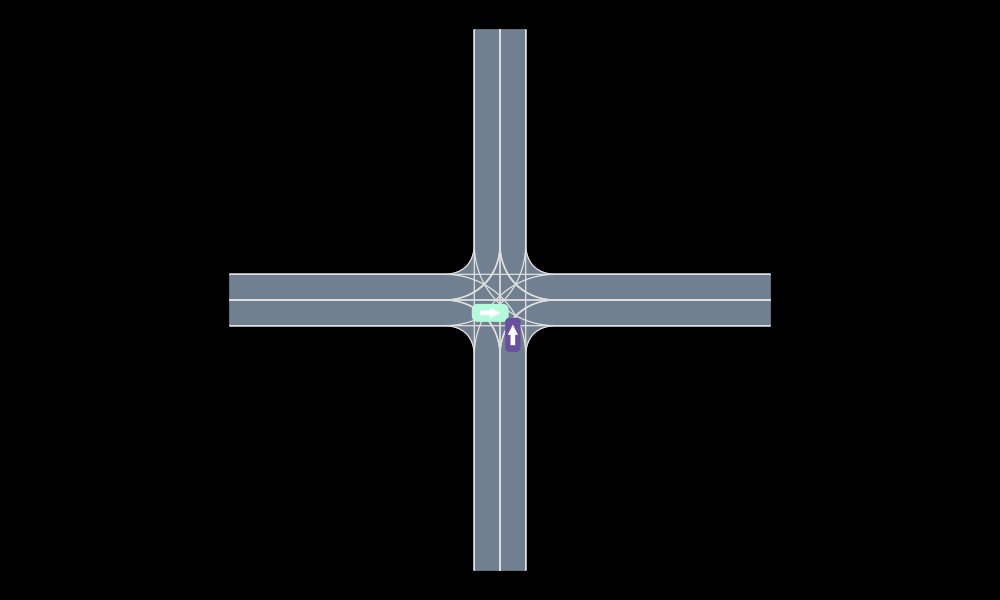

In [969]:
sp, r = @gen(:sp, :r)(mdp, sp, rand(actions(mdp, sp)))
car1 = AutomotiveVisualization.ArrowCar(mdp.sim.state[2])
if typeof(mdp.sim.state[1].state) == NoisyPedState
    car2 = AutomotiveVisualization.FancyPedestrian(ped=mdp.sim.state[1])
else
    car2 = AutomotiveVisualization.ArrowCar(mdp.sim.state[1])
end

@show r
AutomotiveVisualization.render([mdp.sim.roadway, car1, car2])

In [729]:
function update_tree!(amdp, sp, children, a_children, text, tooltip, style, link_style, a, id)
    start_s = sp
    text[id] = (typeof(a)==Float64) ? string(round(a; digits=3)) : string(a)
    tooltip[id] = string(a)
    style[id] = 0.5
    link_style[id] = 0
    
    max_id = id
    curr_children = []
    curr_a_children = Dict()
    a_list = [a for a in get_actions(start_s)]
    width = length(a_list)
    for (c_idx, a) in enumerate(a_list)
        sp = DecisionState(start_s, a)
        if isterminal(amdp, sp)
           continue  
        end
        c_max_id = update_tree!(amdp, sp, children, a_children, text, tooltip, style, link_style, a, max_id + 1)
        push!(curr_children, max_id + 1)
        curr_a_children[a] = c_idx
        max_id = max(max_id, c_max_id)
    end
    children[id] = curr_children
    a_children[id] = curr_a_children
    
    return max_id
end

function create_d3tree(amdp)
    start_s = rand(initialstate(amdp))
    len = 1000_000
    id = 1
    children = Vector{Vector{Int}}(undef, len)
    a_children = Vector{Dict{Any, Int64}}(undef, len)
    text = fill("", len)
    tooltip = fill("", len)
    style = Vector{Any}(undef, len)
    link_style = Vector{Int64}(undef, len)
    
    max_id = update_tree!(amdp, start_s, children, a_children, text, tooltip, style, link_style, "Start", id)
    
    return (
          children[1:max_id],
          text[1:max_id],
          tooltip[1:max_id],
          style[1:max_id],
          link_style[1:max_id],
          a_children[1:max_id]
         )
end

function plot_path(history, amdp; tree_data=nothing)
    
    if tree_data===nothing
        tree_data = create_d3tree(amdp)
    end
    
    s_full = history[end].s
    r = history[end].r
    
    child_idx = 1
    
    # Type
    idx_mask = tree_data[6][child_idx][s_full.scenario_type]
    child_idx = tree_data[1][child_idx][idx_mask]
    tree_data[5][child_idx] += 1
    tree_data[4][child_idx] += (r - tree_data[4][child_idx])/tree_data[5][child_idx]
    
    # Noise Params
    for n_param in s_full.noise_params
        idx_mask = tree_data[6][child_idx][n_param]
        child_idx = tree_data[1][child_idx][idx_mask]
        tree_data[5][child_idx] += 1
        tree_data[4][child_idx] += (r - tree_data[4][child_idx])/tree_data[5][child_idx]
    end
        
    # Init SUT
    for n_param in s_full.init_sut
        idx_mask = tree_data[6][child_idx][n_param]
        child_idx = tree_data[1][child_idx][idx_mask]
        tree_data[5][child_idx] += 1
        tree_data[4][child_idx] += (r - tree_data[4][child_idx])/tree_data[5][child_idx]
    end
    
    # Init ADV
    for n_param in s_full.init_adv
        idx_mask = tree_data[6][child_idx][n_param]
        child_idx = tree_data[1][child_idx][idx_mask]
        tree_data[5][child_idx] += 1
        tree_data[4][child_idx] += (r - tree_data[4][child_idx])/tree_data[5][child_idx]
    end
    
    return tree_data
end

function plot_tree(tree_data; title="Test Tree")
    reward_wts = tree_data[4]/max(tree_data[4]...)
    style = ["stroke:#$(hex(weighted_color_mean(w, colorant"green", colorant"red")))" for w in reward_wts]
    
    width = copy(tree_data[5])
    for i=1:length(tree_data[5])
        if length(tree_data[1][i])==0
            continue
        end
        c_counts = [isnan(tree_data[5][child]) ? 0 : tree_data[5][child] for child in tree_data[1][i]]
        tot_w = sum(c_counts)+1
        for (c_idx, child) in enumerate(tree_data[1][i])
            width[child] = round(c_counts[c_idx]/tot_w*20)
        end
    end
    
    link_style = ["stroke-width:$(w)px" for w in width]
    
    return D3Tree(tree_data[1];
                  text=tree_data[2],
                  tooltip=tree_data[3],
                  style=style,
                  link_style=link_style,
                  title=title
                 )
end

plot_tree (generic function with 1 method)

In [693]:
tree_data = nothing

@showprogress for i=1:1000
    history = POMDPs.simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> rand(actions(amdp, s))), fixed_s);
    tree_data = plot_path(history, amdp; tree_data=tree_data)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [694]:
plot_tree(tree_data)

Start
├──CROSSING
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──T_HEAD_ON
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──T_LEFT
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──STOPPING
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──MERGING
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
└──CROSSWALK
   ├──0.177
   │  ├──0.146 (5 children)
   │  ├──0.158 (5 children)
   │  ├──0.409 (5 children)
   │  ├──0.532 (5 children)

In [730]:
baseline_costs = gen_baseline_costs(amdp, fixed_s; N=N, N_seeds=10);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


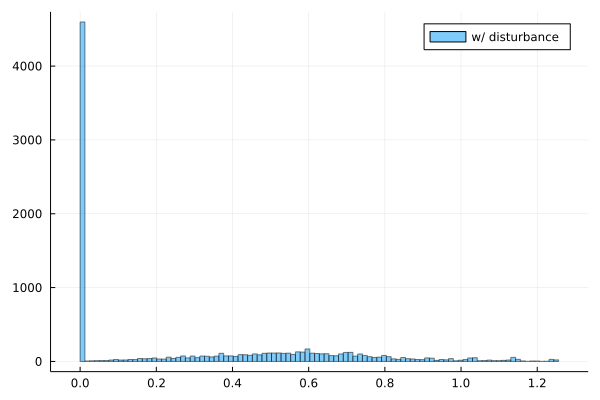

In [731]:
# p = histogram(plot_costs[1][2], label="$(plot_costs[1][1])", alpha=0.4, bins=100)
# for x in plot_costs[end:end]
#     histogram!(x[2], label="$(x[1])", alpha=0.4, bins=100)
# end
# p
max_cost = max(baseline_costs...)
histogram(vcat(baseline_costs...), alpha=0.5, label="w/ disturbance", bins=0:max_cost/100:max_cost)
# histogram!(baseline_costs_1, alpha=0.5, label="w/o disturbance", bins=1:6:600)

In [732]:
# treeis_costs, treeis_logwts, stored_tree = update_treeis(amdp, fixed_s, treeis_params; N=N, stored_tree=stored_tree);
treeis_costs, treeis_weights = gen_treeis_costs(amdp, fixed_s, treeis_params; N=N, N_seeds=10)

"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


"$(strategy_text) strategy" = "VaR strategy"


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


([0.20575221245207675 0.7560087045528634 … 0.21626421655974104 0.6213532821713237; 0.0 0.7013389509280259 … 0.6414015235321577 1.0349643653828575; … ; 0.6010302597155737 0.0 … 0.8491691048441081 0.0; 0.7717729633025581 0.8014525867599274 … 0.0 0.0], [1.0 0.9675373653480308 … 0.491916397856098 1.8934833214105478; 1.0 1.2015751325589465 … 3.6384164033001847 0.5067519568524477; … ; 1.0 0.9675373653480308 … 0.7773913995584907 0.660379165596726; 1.0 0.9675373653480308 … 1.187546785253566 0.9364249398112284])

In [710]:
tis_tree_data = nothing
lookup = TreeImportanceSampling.mdp_state_lookup(stored_tree[2])
# plots = []
@showprogress for i=1:1000
    history = POMDPs.simulate(HistoryRecorder(), amdp, FunctionPolicy((s) -> TreeImportanceSampling.tree_policy(stored_tree[2], s, lookup; params=treeis_params)), fixed_s);
    tis_tree_data = plot_path(history, amdp; tree_data=tis_tree_data)
end
# planner.tree.cdf_est
# planner.tree.total_n
# planner.mdp.costs

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [711]:
plot_tree(tis_tree_data)

Start
├──CROSSING
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──T_HEAD_ON
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──T_LEFT
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──STOPPING
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
├──MERGING
│  ├──0.177
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.223
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.587
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  ├──0.821
│  │  ├──0.146 (5 children)
│  │  ├──0.158 (5 children)
│  │  ├──0.409 (5 children)
│  │  ├──0.532 (5 children)
│  │  └──0.574 (5 children)
│  └──0.994
│     ├──0.146 (5 children)
│     ├──0.158 (5 children)
│     ├──0.409 (5 children)
│     ├──0.532 (5 children)
│     └──0.574 (5 children)
└──CROSSWALK
   ├──0.177
   │  ├──0.146 (5 children)
   │  ├──0.158 (5 children)
   │  ├──0.409 (5 children)
   │  ├──0.532 (5 children)

In [713]:
D3Tree(stored_tree[2].tree.dpw_tree)

DecisionState
  scenario_type: Nothing nothing
  noise_params: Array{Float64}((0,)) Float64[]
  init_sut: Array{Float64}((0,)) Float64[]
  init_adv: Array{Float64}((0,)) Float64[]
  done: Bool false

N:  10000

├──                 CROSSING
│  Q:   0.21
│  N:    911

│  └──DecisionState
│       scenario_type: SCENARIO CROSSING
│       noise_params: Array{Float64}((0,)) Float64[]
│       init_sut: Array{Float64}((0,)) Float64[]
│       init_adv: Array{Float64}((0,)) Float64[]
│       done: Bool false
│     
│     N:    910

│     ├──    [0.17749481098094733]
│     │  Q:   0.19
│     │  N:    208
 (1 children)
│     ├──    [0.22313778811398421]
│     │  Q:   0.28
│     │  N:    177
 (1 children)
│     ├──     [0.5873850932684443]
│     │  Q:   0.16
│     │  N:    158
 (1 children)
│     ├──     [0.8214221242900166]
│     │  Q:   0.19
│     │  N:    225
 (1 children)
│     └──     [0.9937117637940864]
│        Q:   0.22
│        N:    142
 (1 children)
├──                T_HEAD_ON
│  Q:   0.21
│  N:   1564

│  └──DecisionState
│       scenario_type: SCENARIO T_HEAD_ON
│       noise_params: Array{Float64}((0,)) Float64[]
│       init_sut: Array{Float64}((0,)) Float64[]
│       init_adv: Array{Float64}((0,)) Float64[]
│       done: Bool false
│     
│     N:   1563

│     ├──    [0.17749481098094733]
│     │  Q:   0.13
│     │  N:    251
 (1 children)
│     ├──    [0.22313778811398421]
│     │  Q:   0.28
│     │  N:    641
 (1 children)
│     ├──     [0.5873850932684443]
│     │  Q:   0.17
│     │  N:    215
 (1 children)
│     ├──     [0.8214221242900166]
│     │  Q:   0.16
│     │  N:    222
 (1 children)
│     └──     [0.9937117637940864]
│        Q:   0.18
│        N:    234
 (1 children)
├──                   T_LEFT
│  Q:   0.26
│  N:    916

│  └──DecisionState
│       scenario_type: SCENARIO T_LEFT
│       noise_params: Array{Float64}((0,)) Float64[]
│       init_sut: Array{Float64}((0,)) Float64[]
│       init_adv: Array{Float64}((0,)) Float64[]
│       done: Bool false
│     
│     N:    915

│     ├──    [0.17749481098094733]
│     │  Q:   0.25
│     │  N:    219
 (1 children)
│     ├──    [0.22313778811398421]
│     │  Q:   0.29
│     │  N:    160
 (1 children)
│     ├──     [0.5873850932684443]
│     │  Q:   0.21
│     │  N:    127
 (1 children)
│     ├──     [0.8214221242900166]
│     │  Q:   0.26
│     │  N:    261
 (1 children)
│     └──     [0.9937117637940864]
│        Q:   0.26
│        N:    148
 (1 children)
├──                 STOPPING
│  Q:   0.21
│  N:   1875

│  └──DecisionState
│       scenario_type: SCENARIO STOPPING
│       noise_params: Array{Float64}((0,)) Float64[]
│       init_sut: Array{Float64}((0,)) Float64[]
│       init_adv: Array{Float64}((0,)) Float64[]
│       done: Bool false
│     
│     N:   1874

│     ├──    [0.17749481098094733]
│     │  Q:   0.24
│     │  N:    357
 (1 children)
│     ├──    [0.22313778811398421]
│     │  Q:   0.23
│     │  N:    352
 (1 children)
│     ├──     [0.5873850932684443]
│     │  Q:   0.13
│     │  N:    494
 (1 children)
│     ├──     [0.8214221242900166]
│     │  Q:   0.25
│     │  N:    297
 (1 children)
│     └──     [0.9937117637940864]
│        Q:   0.25
│        N:    374
 (1 children)
├──                  MERGING
│  Q:   0.28
│  N:   1056

│  └──DecisionState
│       scenario_type: SCENARIO MERGING
│       noise_params: Array{Float64}((0,)) Float64[]
│       init_sut: Array{Float64}((0,)) Float64[]
│       init_adv: Array{Float64}((0,)) Float64[]
│       done: Bool false
│     
│     N:   1055

│     ├──    [0.17749481098094733]
│     │  Q:   0.27
│     │  N:    288
 (1 children)
│     ├──    [0.22313778811398421]
│     │  Q:   0.34
│     │  N:    259
 (1 children)
│     ├──     [0.5873850932684443]
│     │  Q:   0.25
│     │  N:    154
 (1 children)
│     ├──     [0.8214221242900166]
│     │  Q:   0.29
│     │  N:    143
 (1 children)
│     └──     [0.9937117637940864]
│        Q:   0.25
│        N:    211
 (1 children)
└──                CROSSWALK
  

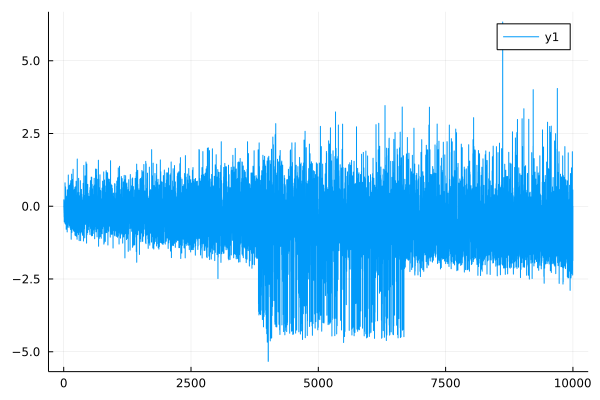

In [717]:
plot(treeis_logwts)

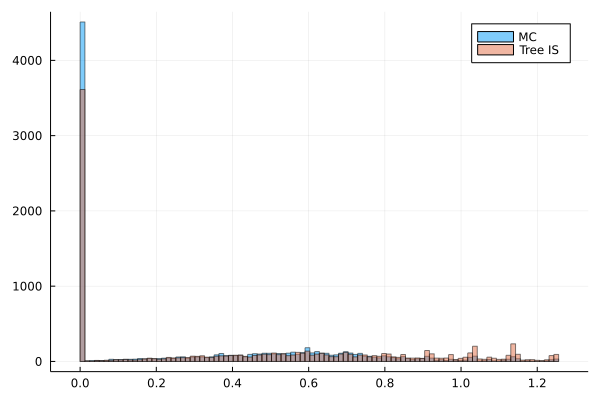

In [721]:
tis_range = (1, length(treeis_costs))
max_cost = max(treeis_costs..., baseline_costs...)
histogram(baseline_costs[tis_range[1]:tis_range[2]], alpha=0.5, label="MC", bins=0:max_cost/100:max_cost)
histogram!(treeis_costs[tis_range[1]:tis_range[2]], alpha=0.5, label="Tree IS", bins=0:max_cost/100:max_cost)
# ylims!(0, 100)

In [ ]:

# print("Baseline metrics")

# TISExperiments.evaluate_metrics(baseline_costs; alpha_list=[1e-3])

# print("\nTIS metrics: N=$(N), c=$(c), α=$(α), β=$(β)), γ=$(γ)")

# TISExperiments.evaluate_metrics(tis_output[1][tis_range[1]:tis_range[2]]; weights=exp.(tis_output[3][tis_range[1]:tis_range[2]]), alpha_list=[1e-3])

# if baseline
# save("$(path)_baseline_$(N).jld2", Dict("risks" => baseline_costs, "states" => []))
# # else
# #     save("$(path)_mcts_IS_$(N).jld2", Dict("risks" => results_tis[1], "states" => results_tis[2], "IS_weights" => results_tis[3], "tree" => results_tis[4]))
# # end

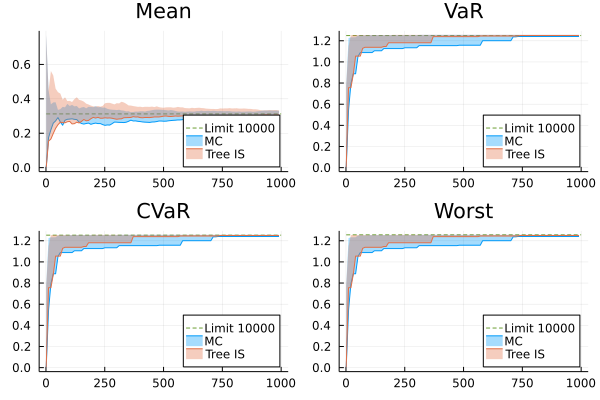

In [733]:
plots = TISExperiments.plot_metrics(baseline_costs, "MC", 1)
plots = TISExperiments.plot_metrics(treeis_costs, "Tree IS", 2; weights=treeis_weights, plots=plots)
plot(plots...)